# Watershed Challenge

## 1. Importing Libraries

In [ ]:
!pip install plotly==4.14.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.2 MB 5.2 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=50fa9c970b67b8b440fdc8bdfae64d8ca877866f17197ddf588e529c51a9ccf9
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying
  Attempting uninstall: plotly
    Found existing installation: plotly 5.5.0
    Uninstalling plotly-5.5.0:
      Successfully uninstalled plotly-5.5.0


In [3]:
#Data Analysis
import numpy as np 
import pandas as pd

# Visualization 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from datetime import datetime 
#pd.options.plotting.backend = "plotly" 
from statsmodels.tsa.seasonal import seasonal_decompose


# Machine Learning 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBRegressor
import xgboost
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Data Processing

### 2.2.1 - Cleaning

In [4]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/watershed/flux.csv")
print(df.shape)
df.head()

(4180480, 10)


,date,basin_id,flux,precip,temp_max,gauge_name,lat,lon,mean_elev,area_km2
0,1980-01-01,1001001,0.579,0.0,10.685653,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859
1,1980-01-02,1001001,0.543,0.0,11.470960,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859
2,1980-01-03,1001001,0.482,0.0,11.947457,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859
3,1980-01-04,1001001,0.459,0.0,12.424489,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859
4,1980-01-05,1001001,0.436,0.0,12.649203,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859


In [5]:
df['date'] = pd.to_datetime(df.date)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4180480 entries, 0 to 4180479
Data columns (total 10 columns):
 #   Column      Dtype         
---  ------      -----         
 0   date        datetime64[ns]
 1   basin_id    int64         
 2   flux        float64       
 3   precip      float64       
 4   temp_max    float64       
 5   gauge_name  object        
 6   lat         float64       
 7   lon         float64       
 8   mean_elev   float64       
 9   area_km2    float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 318.9+ MB


In [7]:
df.isnull().sum()

date             0
basin_id         0
flux             0
precip        5443
temp_max      5443
gauge_name       0
lat              0
lon              0
mean_elev        0
area_km2         0
dtype: int64

In [8]:
print('Dataset size before dropping NaN: {}'.format(df.shape))
data = df.dropna()
print('Dataset size after dropping NaN: {}'.format(data.shape))

Dataset size before dropping NaN: (4180480, 10)
Dataset size after dropping NaN: (4175037, 10)


### 2.2.2 - Feature creation

#### Decomposing the date

In [9]:
data['year'] = data.date.dt.year
data['month'] = data.date.dt.month
data['full_date'] = data.date

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

#### Season

To help visualizing some variables according to the season, this feature is created. In Chile we have:
* Summer: months 12, 01, 02 
* Autumn: months 03, 04, 05
* Winter: months 06, 07, 08 
* Spring: months 09, 10, 11 

In [10]:
seasons_dict = {1: 'Summer', 2:'Summer', 3:'Autumn', 4:'Autumn', 5:'Autumn', 6:'Winter', 7:'Winter', 
                8:'Winter', 9:'Spring', 10:'Spring', 11:'Spring', 12:'Summer'}
data['season'] = data.month.astype(int).map(seasons_dict)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#### Decade

In [11]:
data['decade'] = pd.cut(x=data['year'], bins=[1979, 1989, 1999, 2009, 2019, 2029], 
                          labels=['1980', '1990', '2000', '2010', '2020'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## 3. Statistical Analysis

In [12]:
data.set_index("date", inplace=True)
data['decade'] = data.decade.astype(str)
data['season'] = data.season.astype(str)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### 3.3.1 - Statistics by Time of Year

In [13]:
df_summer = data[data['season']=='Summer']
df_spring = data[data['season']=='Spring']
df_winter = data[data['season']=='Winter']
df_autumn = data[data['season']=='Autumn']

#### Yearlong 

In [14]:
data[['flux', 'precip', 'temp_max', 'mean_elev', 'area_km2']].describe().apply(lambda s: s.apply('{0:.5f}'.format))

,flux,precip,temp_max,mean_elev,area_km2
count,4175037.00000,4175037.00000,4175037.00000,4175037.00000,4175037.00000
mean,52.49398,2.94745,13.65728,1760.14921,2403.91480
std,167.41563,8.76675,6.61504,1382.30237,4321.22934
min,0.00000,0.00000,-11.60359,118.12295,17.89123
25%,0.86900,0.00000,9.16287,584.70119,376.10009
50%,5.18000,0.00000,13.21396,1195.31114,820.55412
75%,29.90000,0.64226,18.05745,3048.16115,2461.60953
max,15805.00000,213.21202,40.81117,4910.15184,52243.66709


#### Summer

In [15]:
df_summer[['flux', 'precip', 'temp_max', 'mean_elev', 'area_km2']].describe().apply(lambda s: s.apply('{0:.5f}'.format))

,flux,precip,temp_max,mean_elev,area_km2
count,1041105.00000,1041105.00000,1041105.00000,1041105.00000,1041105.00000
mean,38.94754,1.29610,18.76732,1779.71492,2395.76462
std,122.25654,4.47423,5.74972,1394.49687,4313.97181
min,0.00000,0.00000,-3.77704,118.12295,17.89123
25%,0.66800,0.00000,14.11804,590.69250,376.10009
50%,3.82000,0.00000,18.56359,1197.11829,820.55412
75%,20.80000,0.05827,23.24188,3071.22203,2461.60953
max,4359.00000,163.61475,40.81117,4910.15184,52243.66709


#### Autumn

In [16]:
df_autumn[['flux', 'precip', 'temp_max', 'mean_elev', 'area_km2']].describe().apply(lambda s: s.apply('{0:.5f}'.format))

,flux,precip,temp_max,mean_elev,area_km2
count,1056597.00000,1056597.00000,1056597.00000,1056597.00000,1056597.00000
mean,37.80255,2.98100,14.22334,1762.41872,2398.48737
std,139.23460,9.12179,5.78605,1387.21614,4259.83788
min,0.00000,0.00000,-8.97085,118.12295,17.89123
25%,0.64300,0.00000,10.18294,584.70119,378.99341
50%,3.32000,0.00000,13.96381,1194.82870,829.60317
75%,17.30000,0.52821,18.14997,3048.16115,2462.83985
max,12933.00000,213.21202,35.54676,4910.15184,52243.66709


#### Winter

In [17]:
df_winter[['flux', 'precip', 'temp_max', 'mean_elev', 'area_km2']].describe().apply(lambda s: s.apply('{0:.5f}'.format))

,flux,precip,temp_max,mean_elev,area_km2
count,1039615.00000,1039615.00000,1039615.00000,1039615.00000,1039615.00000
mean,76.25774,5.33001,8.39477,1740.17479,2404.70378
std,230.53221,12.32382,4.89109,1369.22447,4295.39936
min,0.00000,0.00000,-11.60359,118.12295,17.89123
25%,1.19000,0.00000,5.04879,581.22111,378.99341
50%,8.41000,0.00000,8.55114,1184.05638,820.55412
75%,46.90000,4.21086,11.86572,2949.79301,2461.60953
max,15805.00000,203.09468,29.79837,4910.15184,52243.66709


#### Spring

In [18]:
df_spring[['flux', 'precip', 'temp_max', 'mean_elev', 'area_km2']].describe().apply(lambda s: s.apply('{0:.5f}'.format))

,flux,precip,temp_max,mean_elev,area_km2
count,1037720.00000,1037720.00000,1037720.00000,1037720.00000,1037720.00000
mean,57.23613,2.18309,13.22632,1758.21978,2416.82733
std,154.25925,6.57617,5.51167,1377.74965,4415.31978
min,0.00000,0.00000,-9.01259,118.12295,17.89123
25%,1.17000,0.00000,9.41962,584.70119,376.10009
50%,8.21000,0.00000,12.99495,1195.31114,820.55412
75%,38.90000,0.22986,16.97324,3037.62033,2461.60953
max,7635.00000,162.41408,35.67375,4910.15184,52243.66709


#### Percentiles

In [19]:
#Getting 95% percentiles for each variable and each time of the year

#FLUX
p_flux_summer = np.percentile(df_summer.flux, 95)
p_flux_autumn = np.percentile(df_autumn.flux, 95)
p_flux_winter = np.percentile(df_winter.flux, 95)
p_flux_spring = np.percentile(df_spring.flux, 95)
p_flux_yearlong = np.percentile(data.flux, 95)

p99_flux_summer = np.percentile(df_summer.flux, 99)
p99_flux_autumn = np.percentile(df_autumn.flux, 99)
p99_flux_winter = np.percentile(df_winter.flux, 99)
p99_flux_spring = np.percentile(df_spring.flux, 99)
p99_flux_yearlong = np.percentile(data.flux, 99)

#Max_temp 
p_mtemp_summer = np.percentile(df_summer.temp_max, 95)
p_mtemp_autumn = np.percentile(df_autumn.temp_max, 95)
p_mtemp_winter = np.percentile(df_winter.temp_max, 95)
p_mtemp_spring = np.percentile(df_spring.temp_max, 95)
p_mtemp_yearlong = np.percentile(data.temp_max, 95)

p99_mtemp_summer = np.percentile(df_summer.temp_max, 99)
p99_mtemp_autumn = np.percentile(df_autumn.temp_max, 99)
p99_mtemp_winter = np.percentile(df_winter.temp_max, 99)
p99_mtemp_spring = np.percentile(df_spring.temp_max, 99)
p99_mtemp_yearlong = np.percentile(data.temp_max, 99)

#Precipitation 
p_precip_summer = np.percentile(df_summer.precip, 95)
p_precip_autumn = np.percentile(df_autumn.precip, 95)
p_precip_winter = np.percentile(df_winter.precip, 95)
p_precip_spring = np.percentile(df_spring.precip, 95)
p_precip_yearlong = np.percentile(data.precip, 95)

p99_precip_summer = np.percentile(df_summer.precip, 99)
p99_precip_autumn = np.percentile(df_autumn.precip, 99)
p99_precip_winter = np.percentile(df_winter.precip, 99)
p99_precip_spring = np.percentile(df_spring.precip, 99)
p99_precip_yearlong = np.percentile(data.precip, 99)

#### Upper and lower outliers

In [20]:
# Upper_outlier = Q3 - 1.5*Q1
#Lower outlier = Q1 - 1.5*IQR
up_flu_summer = 20.8 + 1.5*0.668
up_flu_autumn = 17.3 + 1.5*0.643
up_flu_winter = 46.9 + 1.5*1.19
up_flu_spring = 38.9 + 1.5*1.17
up_flu_year  =  29.9 + 1.5*0.869

up_pre_summer = 0.05827 + 1.5*0
up_pre_autumn = 0.52821 + 1.5*0
up_pre_winter = 4.21  + 1.5*0
up_pre_spring = 0.22986 + 1.5*0
up_pre_year  =  0.64226 + 1.5*0

up_temp_summer = 23.24188 + 1.5*14.11804
up_temp_autumn = 18.14997 + 1.5*10.18294
up_temp_winter = 11.86572 + 1.5*5.04879
up_temp_spring = 16.97324 + 1.5*9.41962
up_temp_year  = 18.05745  + 1.5*9.16287

low_temp_summer = 14.11804 - 1.5*9.13
low_temp_autumn = 10.18294 - 1.5*7.97
low_temp_winter = 5.04879 - 1.5*6.81
low_temp_spring = 9.41962 - 1.5*7.56
low_temp_year  = 9.16287 - 1.5*8.9

#### Statistics table for Precipitation

In [21]:
#Table for precipitation
time_of_year = ['Summer', 'Autumn', 'Winter', 'Spring', 'Year_long']
IQR_pre = [0.06, 0.52, 4.21, 0.23, 0.64]
avg_pre = [1.29, 2.98, 5.33 , 2.18, 2.95]
median_pre = [df_summer.precip.median(), df_autumn.precip.median(), df_winter.precip.median(), 
              df_spring.precip.median(), data.precip.median()]
max_pre = [163.61, 213.21, 203.095, 162.41, 213.21]
perc_95 = [p_precip_summer, p_precip_autumn, p_precip_winter, p_precip_spring, p_precip_yearlong]
perc_99 = [p99_precip_summer, p99_precip_autumn, p99_precip_winter, p99_precip_spring, p99_precip_yearlong]
up_out_pre = [up_pre_summer, up_pre_autumn, up_pre_winter, up_pre_spring, up_pre_year]

zippedList =  list(zip(time_of_year, IQR_pre, avg_pre, median_pre, max_pre, perc_95, perc_99, up_out_pre))
precipitation = pd.DataFrame(zippedList, columns = ['Time_of_year' , 'IQR', 'Mean', 'Median', 'Max_precip', '95_percentile', '99_percentile', 'Upper_outlier']) 
precipitation

,Time_of_year,IQR,Mean,Median,Max_precip,95_percentile,99_percentile,Upper_outlier
0,Summer,0.06,1.29,0.0,163.610,7.404016,21.743726,0.05827
1,Autumn,0.52,2.98,0.0,213.210,18.092802,45.121845,0.52821
2,Winter,4.21,5.33,0.0,203.095,30.503264,59.160918,4.21000
3,Spring,0.23,2.18,0.0,162.410,13.672440,32.695564,0.22986
4,Year_long,0.64,2.95,0.0,213.210,18.219892,43.721935,0.64226


#### Statistics table for Flux

In [22]:
#Table for flux
#Upper outlier = Q1 - 1.5*IQR
IQR_flu = [20.13, 16.66 , 45.71 , 37.73 , 29.03]
avg_flu = [38.94, 37.80, 76.26 , 57.24, 52.49]
median_flu = [df_summer.flux.median(), df_autumn.flux.median(), df_winter.flux.median(), 
              df_spring.flux.median(), data.flux.median()]
max_flu = [4359, 12933, 15805, 7635, 15805]
perc_95f = [p_flux_summer, p_flux_autumn, p_flux_winter, p_flux_spring, p_flux_yearlong]
perc_99f = [p99_flux_summer, p99_flux_autumn, p99_flux_winter, p99_flux_spring, p99_flux_yearlong]
up_out_flu = [up_flu_summer, up_flu_autumn, up_flu_winter, up_flu_spring, up_flu_year]

zippedList2 =  list(zip(time_of_year, IQR_flu, avg_flu, median_flu, max_flu, perc_95f, perc_99f, up_out_flu))
flux = pd.DataFrame(zippedList2, columns = ['Time_of_year', 'IQR', 'Mean', 'Median', 'Max_flux', '95_percentile', '99_percentile', 'Upper_outlier']) 
flux

,Time_of_year,IQR,Mean,Median,Max_flux,95_percentile,99_percentile,Upper_outlier
0,Summer,20.13,38.94,3.82,4359,185.0,661.0,21.8020
1,Autumn,16.66,37.80,3.32,12933,170.0,718.0,18.2645
2,Winter,45.71,76.26,8.41,15805,407.0,1000.0,48.6850
3,Spring,37.73,57.24,8.21,7635,310.0,738.0,40.6550
4,Year_long,29.03,52.49,5.18,15805,262.0,790.0,31.2035


#### Statistics table for max temperature

In [23]:
#Table for maximum temperature
IQR_temp = [9.13, 7.97, 6.81, 7.56, 8.9]
avg_temp = [18.77, 14.22, 8.39, 13.23, 13.66]
median_temp = [df_summer.temp_max.median(), df_autumn.temp_max.median(), df_winter.temp_max.median(), 
              df_spring.temp_max.median(), data.temp_max.median()]
max_temp = [40.8, 35.55, 29.79, 35.67, 40.8]
perc_95t = [p_mtemp_summer, p_mtemp_autumn, p_mtemp_winter, p_mtemp_spring, p_mtemp_yearlong]
perc_99t = [p99_mtemp_summer, p99_mtemp_autumn, p99_mtemp_winter, p99_mtemp_spring, p99_mtemp_yearlong]
up_out_temp = [up_temp_summer, up_temp_autumn, up_temp_winter, up_temp_spring, up_temp_year]
low_out_temp = [low_temp_summer, low_temp_autumn, low_temp_winter, low_temp_spring, low_temp_year]

zippedList2 =  list(zip(time_of_year, IQR_temp, avg_temp, median_temp, max_temp, perc_95t, perc_99t, up_out_temp, low_out_temp))
temperature = pd.DataFrame(zippedList2, columns = ['Time_of_year', 'IQR', 'Mean', 'Median', 'Max_temp', '95_percentile', '99_percentile', 
                                                   'Upper_outlier', 'Lower_outlier' ]) 
temperature

,Time_of_year,IQR,Mean,Median,Max_temp,95_percentile,99_percentile,Upper_outlier,Lower_outlier
0,Summer,9.13,18.77,18.563586,40.80,28.260483,30.857427,44.418940,0.42304
1,Autumn,7.97,14.22,13.963813,35.55,24.159966,27.527323,33.424380,-1.77206
2,Winter,6.81,8.39,8.551136,29.79,16.085831,19.377397,19.438905,-5.16621
3,Spring,7.56,13.23,12.994946,35.67,22.571383,26.045631,31.102670,-1.92038
4,Year_long,8.90,13.66,13.213956,40.80,25.247571,28.958991,31.801755,-4.18713


### 3.3.2 - Outliers by decade

In [24]:
outlier_df = data[['flux', 'temp_max', 'precip', 'season', 'decade']]

#Lets exclude the days in which there was no flux and no precipitation so that we can visualize better
outlier_flux = outlier_df.query('flux>0') 
outlier_flux.shape

(4174583, 5)

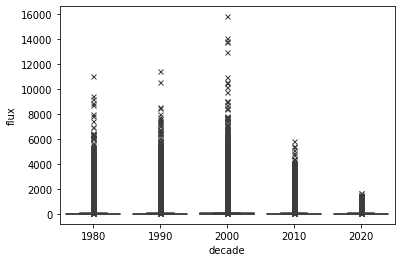

In [25]:
sns.boxplot(data=outlier_flux, x="decade", y='flux', flierprops={"marker": "x"},)

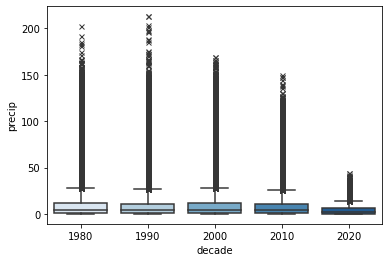

In [26]:
outlier_precip = outlier_df.query('precip>0') 
sns.boxplot(data=outlier_precip, x="decade", y='precip', palette="Blues",  flierprops={"marker": "x"},)

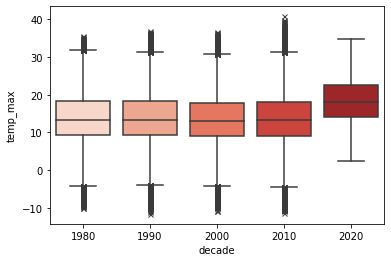

In [27]:
sns.boxplot(data=outlier_df, x="decade", y='temp_max', palette='Reds', flierprops={"marker": "x"})

### 3.3.3 - Outliers by season

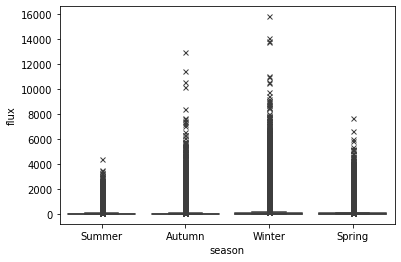

In [28]:
sns.boxplot(data=outlier_flux, x="season", y='flux', flierprops={"marker": "x"})

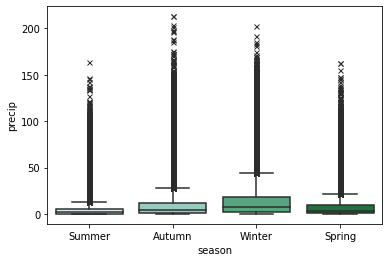

In [29]:
sns.boxplot(data=outlier_precip, x="season", y='precip', palette='BuGn', flierprops={"marker": "x"})

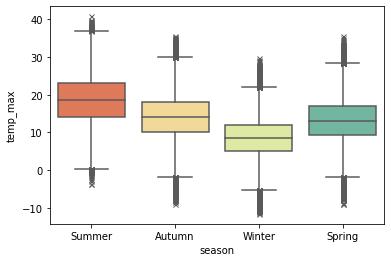

In [30]:
sns.boxplot(data=outlier_df, x="season", y='temp_max', palette='Spectral', flierprops={"marker": "x"})

### 3.3.4 - Remarks on statistical analysis

**Main conclusions from statistical analysis**

*BY SEASONS*

* On average, it seems to rain more on winter time. 
* The average max temperature considering the whole year is a few degrees lower than the average max temperature for Summer and Autumn and a few degrees higher than the one for the Winter. 
* We have the highest outliers for flux in winter and the lowest in summer. 
* For precipitation we can see that IQR for winter is broader, which makes some values for precipitation and outlier in other seasons  but not in winter.
* On the other hand, the highest outliers values for precipitation happned in autumn. 

*BY DECADE*
* Looking at precipitation by decade we can see that the 1990s had the highest volume of rain in 40 years. On the other hand, the largest watershed episodes happened in the 2000s. This gives us a hint that maybe more precipitation does not coincide with watersheds. 

* Temperature seems to have a stable behaviour over the decades, with some of the warmest days in the period happening in the 1980s and 2010s.

* Largest flood events happened in the 2000s. But largest temperatures in winter

*EXTREME EVENTS**
* Max flux recorded in the period of this study did not coincide with maximum rain or temperature. This happened in wintertime in 2000 on a day with maximum temperature of 7 degrees celsis. 

* Upper outlier for flux by season is lower than the average value for all seasons, This means that we have a great number of episodes of extreme high flux. For this case it seems logical to use the 95 percentile to classify extreme events. The 99 percentile is already too far away from the mean and the upper outlier values. 

* For precipitiation, upper outlier in winter is clearly different from other seasons but still very far from the 95 and 99 percentiles and maximum values. Moreover, in all cases the upper outlier is lower than the average value, meaning that there are several episodes of high volumes of precipitation. The 95 percentile also seems like a good choice to capture extreme events. 

* For maximum temperatures we can clearly see from upper and lower outliers that what is an outlier in winter is completly different from what is an outlier in other seasons. 
Moreover, in this case the upper outlier is higher than the average value for all seasons. The 95 percentile is higher than the mean for all cases soo this will be implemented for capturing extreme temperatures.

## 4. EDA

### 4.1 - Extreme Variables

#### 4.1.1 - Did the maximum flood coincide with maximum precipitation or temperature? 

In [31]:
data[data['flux']==15805]

,basin_id,flux,precip,temp_max,gauge_name,lat,lon,mean_elev,area_km2,year,month,full_date,season,decade
date,,,,,,,,,,,,,,
2000-07-01,7383001,15805.0,12.880189,7.399687,Rio Maule En Forel,-35.4069,-72.2083,890.298172,20514.601934,2000,7,2000-07-01,Winter,2000


#### 4.1.2 - Extreme variables with 95 percentile

In [32]:
df_summer['flux_extreme'] = df_summer.flux.apply(lambda x: 1 if x>p_flux_summer else 0)
df_summer['temp_extreme'] = df_summer.temp_max.apply(lambda x: 1 if x>p_mtemp_summer else 0)
df_summer['precip_extreme'] = df_summer.precip.apply(lambda x: 1 if x>p_precip_summer else 0)

df_autumn['flux_extreme'] = df_autumn.flux.apply(lambda x: 1 if x>p_flux_autumn else 0)
df_autumn['temp_extreme'] = df_autumn.temp_max.apply(lambda x: 1 if x>p_mtemp_autumn else 0)
df_autumn['precip_extreme'] = df_autumn.precip.apply(lambda x: 1 if x>p_precip_autumn else 0)


df_winter['flux_extreme'] = df_winter.flux.apply(lambda x: 1 if x>p_flux_winter else 0)
df_winter['temp_extreme'] = df_winter.temp_max.apply(lambda x: 1 if x>p_mtemp_winter else 0)
df_winter['precip_extreme'] = df_winter.precip.apply(lambda x: 1 if x>p_precip_winter else 0)

df_spring['flux_extreme'] = df_spring.flux.apply(lambda x: 1 if x>p_flux_spring else 0)
df_spring['temp_extreme'] = df_spring.temp_max.apply(lambda x: 1 if x>p_mtemp_spring else 0)
df_spring['precip_extreme'] = df_spring.precip.apply(lambda x: 1 if x>p_precip_spring else 0)

final_df = pd.concat([df_summer, df_autumn, df_winter, df_spring])
print(final_df.shape)
final_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

(4175037, 17)


,basin_id,flux,precip,temp_max,gauge_name,lat,lon,mean_elev,area_km2,year,month,full_date,season,decade,flux_extreme,temp_extreme,precip_extreme
date,,,,,,,,,,,,,,,,,
1980-01-01,1001001,0.579,0.0,10.685653,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,1980,1,1980-01-01,Summer,1980,0,0,0
1980-01-02,1001001,0.543,0.0,11.470960,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,1980,1,1980-01-02,Summer,1980,0,0,0
1980-01-03,1001001,0.482,0.0,11.947457,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,1980,1,1980-01-03,Summer,1980,0,0,0
1980-01-04,1001001,0.459,0.0,12.424489,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,1980,1,1980-01-04,Summer,1980,0,0,0
1980-01-05,1001001,0.436,0.0,12.649203,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,1980,1,1980-01-05,Summer,1980,0,0,0


### 4.2 - Plots for extreme variables

#### 4.2.1 - Extreme flux by year

In [33]:
final_year_flu = final_df.groupby(['flux_extreme', 'year']).size().reset_index()
final_year_flu = final_year_flu.sort_values(by = ['year', 'flux_extreme'], ascending=True)
final_year_flu['percentage'] = final_df.groupby([ 'year', 'flux_extreme']).size().groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).values
final_year_flu.columns = ['flux_extreme', 'year', 'Count', 'Percentage']

In [34]:
#Flux_extreme variable in bar plots per year including the percentage of events: 

fig1 = px.bar(final_year_flu, x='year', y=['Count'], color='flux_extreme', 
              color_discrete_sequence=['Midnightblue', 'Firebrick'],
              text=final_year_flu['Percentage'].apply(lambda x: '{0:1.2f}%'.format(x)))

fig1.update_layout(barmode='stack', title={'text': 'Extreme flux events in % over the years', 
                                           'x':0.5, 
                                           'xanchor': 'center'})
fig1.update_layout(
    hoverlabel=dict(
        bgcolor="white",
        font_size=13,
        font_family="Rockwell"
    ), legend=dict(yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.77))
fig1.show()

#### 4.2.2 - Extreme flux by decade

In [35]:
final_dec_flu = final_df.groupby(['flux_extreme', 'decade']).size().reset_index()
final_dec_flu = final_dec_flu.sort_values(by = ['decade', 'flux_extreme'], ascending=True)
final_dec_flu['percentage'] = final_df.groupby([ 'decade', 'flux_extreme']).size().groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).values
final_dec_flu.columns = ['flux_extreme', 'decade', 'Count', 'Percentage']

In [36]:
#Flux_extreme variable in bar plots per decade including the percentage of events: 

fig2 = px.bar(final_dec_flu, x='decade', y=['Count'], color='flux_extreme', 
              color_discrete_sequence=['Midnightblue', 'Firebrick'],
              text=final_dec_flu['Percentage'].apply(lambda x: '{0:1.2f}%'.format(x)))

fig2.update_layout(barmode='stack', title={'text': 'Extreme flux events in % over the decades', 
                                           'x':0.5, 
                                           'xanchor': 'center'})
fig2.update_layout(
    hoverlabel=dict(
        bgcolor="white",
        font_size=13,
        font_family="Rockwell"
    ), legend=dict(yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.77))
fig2.show()

In [37]:
final_df.decade.value_counts()

2010    1189754
2000    1154565
1990     979795
1980     830534
2020      20389
Name: decade, dtype: int64

In [38]:
#Are there more gauges measuring events from the 2000s onwards? 

gauges = final_df.groupby(['gauge_name', 'flux_extreme', 'decade']).size().reset_index()
gauges.columns = ['gauge_name', 'flux_extreme', 'decade', 'Count']
#gauges

In [39]:
gauges_1980s = gauges[gauges['decade']=='1980']
gauges_1990s = gauges[gauges['decade']=='1990']
gauges_2000s = gauges[gauges['decade']=='2000']
gauges_2010s = gauges[gauges['decade']=='2010']
gauges_2020s = gauges[gauges['decade']=='2020']

print('NUMBER OF DIFFERENT GAUGES OVER THE DECADES:')
print('Unique gauges in the 1980s: {}'.format(len(gauges_1980s['gauge_name'].unique())))
print('Unique gauges in the 1990s: {}'.format(len(gauges_1990s['gauge_name'].unique())))
print('Unique gauges in the 2000s: {}'.format(len(gauges_2000s['gauge_name'].unique())))
print('Unique gauges in the 2010s: {}'.format(len(gauges_2010s['gauge_name'].unique())))
print('Unique gauges in the 2020s: {}'.format(len(gauges_2020s['gauge_name'].unique())))

NUMBER OF DIFFERENT GAUGES OVER THE DECADES:
Unique gauges in the 1980s: 354
Unique gauges in the 1990s: 327
Unique gauges in the 2000s: 409
Unique gauges in the 2010s: 422
Unique gauges in the 2020s: 192


**Some remarks**

* This plot clearly shows that the absolute number of extreme flux events increase over the years but also the number of measurements increased. This gives us the false impression that the percentage of extreme flux is decreasing. We must keep in mind, from the outliers analysis, that the largest flood events happened in the 2000s. 

* The number of unique gauges increased considerably in the 2000s in comparison with the 1980s, so maybe collecting information from different locations will help in the predictions.

* Maybe for the sake of consistency, we should consider only data from the 2000s onwards in the prediction model, due to the increase in measurement points starting in the 2000s. 

#### 4.2.3 - Are there extreme events coinciding? 

In [40]:
final_df['Extr_Flux_Precip'] = np.where( (final_df['flux_extreme'] == 1) & (final_df['precip_extreme']==1), 1, 0 )   #When there are extreme flux and precipitation
final_df['Extr_Flux_Temp'] = np.where( (final_df['flux_extreme'] == 1) & (final_df['temp_extreme']==1), 1, 0 )       #When there are extreme flux and precipitation
final_df['Extr_Flux_Precip_Temp'] = np.where( (final_df['flux_extreme'] == 1) & (final_df['precip_extreme']==1)
 & (final_df['temp_extreme']==1), 1, 0 )   #When there are extreme flux, temperature and precipitation

In [41]:
final_df.Extr_Flux_Precip.value_counts(normalize=True)

0    0.993537
1    0.006463
Name: Extr_Flux_Precip, dtype: float64

In [42]:
final_df.Extr_Flux_Temp.value_counts(normalize=True)

0    0.999109
1    0.000891
Name: Extr_Flux_Temp, dtype: float64

In [43]:
final_df.Extr_Flux_Precip_Temp.value_counts(normalize=True)

0    9.999995e-01
1    4.790377e-07
Name: Extr_Flux_Precip_Temp, dtype: float64

Extreme flux and precipitation events happened in 0.64% of times, while extreme flux and extreme temperature happened in 0.08% of times. The three extreme events happening at the same time is much more unlikely. 

The task of the machine learning model will be to look at the historical events and try to predict based on the accumulated effect of spaced events (extreme precipitation , extreme temperature). This seem like a more realistic approach for the prediction of wheather phenomena, as things seem to happen after an accumulation of episodes and not due to specific

#### 4.2.4 - Plots of flux, precipitation and max temp for the whole period

In [44]:
#data_gp = data.groupby(['date'])
data_gp = final_df.groupby('full_date').sum().reset_index()
data_gp.head()

,full_date,basin_id,flux,precip,temp_max,lat,lon,mean_elev,area_km2,year,month,flux_extreme,temp_extreme,precip_extreme,Extr_Flux_Precip,Extr_Flux_Temp,Extr_Flux_Precip_Temp
0,1980-01-01,1203669298,5351.640,3.967833,3947.146684,-6438.5841,-13661.6645,373322.720891,369849.130409,380160,192,7,19,0,0,0,0
1,1980-01-02,1198936297,5243.407,0.794209,3757.443392,-6407.3019,-13590.7478,370327.638917,368556.331976,378180,191,6,9,0,0,0,0
2,1980-01-03,1195037297,5042.667,0.491791,3807.911661,-6398.7305,-13589.2514,372703.880114,376400.897507,378180,191,6,6,0,0,0,0
3,1980-01-04,1207090299,4911.053,3.679436,3637.055222,-6466.6671,-13731.8391,376466.232153,377926.575410,382140,193,5,3,0,0,0,0
4,1980-01-05,1191245296,4723.921,3.820313,3850.723611,-6389.8313,-13588.9722,373732.582085,375182.904456,378180,191,5,12,0,0,0,0


In [45]:
fig3 = px.line(data_gp,  x = 'full_date', y='flux', title='Flux over the years', color_discrete_sequence= ['dodgerblue'],
               labels=dict(x="Date", y="Flux"))
fig3.layout.template = 'ggplot2'
fig3.update_layout(
    hoverlabel=dict(
        bgcolor="white",
        font_size=12
    ))
fig3.show()

In [46]:
#temp_df = data['date', 'temp'].groupby('date').mean().reset_index()
temp_df = final_df.pivot_table("temp_max", ['full_date'], aggfunc="mean").reset_index()
temp_df.head()

,full_date,temp_max
0,1980-01-01,20.558056
1,1980-01-02,19.672478
2,1980-01-03,19.936710
3,1980-01-04,18.844846
4,1980-01-05,20.160857


In [47]:
fig4 = px.line(temp_df,  x = 'full_date', y='temp_max', title='Max temperature for all stations over the years', color_discrete_sequence= ['firebrick'],
               labels=dict(x="Date", y="Flux"))
fig4.layout.template = 'ggplot2'
fig4.update_layout(
    hoverlabel=dict(
        bgcolor="white",
        font_size=12
    ))
fig4.show()

In [48]:
fig5 = px.line(data_gp,  x = 'full_date', y='precip', title='Precipitation for all stations (cumulative) over the years', color_discrete_sequence= ['indigo'],
               labels=dict(x="Date", y="Flux"))
fig5.layout.template = 'ggplot2'
fig5.update_layout(
    hoverlabel=dict(
        bgcolor="white",
        font_size=12
    ))
fig5.show()

#### 4.2.5 - Function to plot one time series

In [49]:
def plot_one_timeserie(cod_station, variable, min_date, max_date):
  func = final_df[final_df['basin_id']== cod_station]
  func = func[(func['full_date']>= min_date) & (func['full_date']<= max_date)]
  fig = px.line(func,  x = 'full_date', y=variable , color_discrete_sequence= ['indigo'])
  fig.layout.template = 'ggplot2'
  fig.update_layout(hoverlabel=dict(bgcolor="white", font_size=12))
  return fig.show()

In [50]:
plot_one_timeserie(1001001, 'flux','1980-07-07', '1980-12-31')

#### 4.2.6 - Does elevation matter?

In [51]:
extr_flux_df = final_df[final_df['flux_extreme']==1]
normal_flux_df = final_df[final_df['flux_extreme']==0]

In [52]:
extr_flux_df[['mean_elev', 'temp_max', 'precip', 'area_km2']].describe()

,mean_elev,temp_max,precip,area_km2
count,208285.000000,208285.000000,208285.000000,208285.000000
mean,946.890921,12.770923,6.901417,10250.267679
std,379.138802,5.613268,13.350158,7121.805635
min,143.285640,-4.891671,0.000000,66.986416
25%,801.047714,8.710946,0.000000,5152.533974
50%,898.693933,12.017519,0.706400,8574.609649
75%,1032.344783,16.221048,8.056210,13766.639171
max,3737.182280,35.931209,164.121240,27402.563558


In [53]:
normal_flux_df[['mean_elev', 'temp_max', 'precip', 'area_km2']].describe().describe().apply(lambda s: s.apply('{0:.5f}'.format))

,mean_elev,temp_max,precip,area_km2
count,8.00000,8.00000,8.00000,8.00000
mean,497491.14959,495855.27525,495872.08984,503481.29590
std,1401793.89661,1402454.06343,1402447.27118,1399485.91983
min,118.12295,-11.60359,0.00000,17.89123
25%,1076.52704,8.56220,0.00000,669.09449
50%,1602.67290,13.49389,1.55011,2006.85954
75%,3576.20335,23.81546,59.60788,15825.55219
max,3966752.00000,3966752.00000,3966752.00000,3966752.00000


**Some remarks**
* Extreme flux events seems to happen more often in lower altitudes, as expected. The average altitude is 946 m and in most cases (75%) the altitude is below 1000 m. 
* It seems that in altitudes higher than 3500m is less likely to occur a watershed event, so this information will be useful for the machine learning model. 

## 5. Time Series Model for the Whole Period


### 5.1 - Data Preparation

The information on the season is implicit in the definition of extreme variables , as these variables where defined according to the 95 percentile for each season. To avoid feature redundancy, 'season' will not be considered as a feature. So we will have the following:

* X(features) = temp_extreme, precip_extreme, mean_elev, year, month
* Y(prediction) = Extreme_flux 

In [54]:
final_df = final_df.sort_index()
X = final_df[['temp_extreme', 'precip_extreme', 'flux_extreme', 'mean_elev', 'year', 'month']]
y = final_df[['flux']]

In [55]:
X.head(2)

,temp_extreme,precip_extreme,flux_extreme,mean_elev,year,month
date,,,,,,
1980-01-01,0,0,0,4842.449328,1980,1
1980-01-01,0,0,0,340.801592,1980,1


In [56]:
X.tail(2)

,temp_extreme,precip_extreme,flux_extreme,mean_elev,year,month
date,,,,,,
2020-04-29,0,0,0,1932.817390,2020,4
2020-04-30,0,0,1,801.047714,2020,4


In [57]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [58]:
#Train test split 
#Considering only data from 2000s onwards because the number of gauges increased considerably from the 1990s to the 2000s

X_train = X['2000-01-01':'2015-01-01']
X_test  = X['2015-01-02':]
y_train = y['2000-01-01':'2015-01-01']
y_test  = y['2015-01-02':]

print(X_train.shape)
print(X_test.shape)

(1775425, 6)
(589283, 6)


In [59]:
(X_test.shape[0]/X.shape[0])*100

14.114437788216009

### 5.2 - Model Implementation

As a baseline model we will implement XGBoost Regressor as tree models are a good starting point when we have a problem that seem to have complex relationships among

In [60]:
#model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model = XGBRegressor()
model.fit(X_train, y_train)
testpred = model.predict(X_test)

[17:08:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


### 5.3 - Evaluation

In [61]:
testpred

array([1.7664999e-01, 1.0729078e+01, 5.1497693e+00, ..., 4.1197522e+02,
       1.6068745e+01, 5.0835172e+02], dtype=float32)

In [62]:
from sklearn.metrics import mean_squared_log_error, mean_squared_error
#RMSLE = np.sqrt( mean_squared_log_error(y_test, testpred) )

RMSE = mean_squared_error(y_test, testpred, squared=False)
print("The score is %.5f" % RMSE )

The score is 79.16390


In [63]:
y_train.describe()

,flux
count,1.775425e+06
mean,6.306045e+01
std,1.890715e+02
min,0.000000e+00
25%,8.600000e-01
50%,5.550000e+00
75%,3.510000e+01
max,1.580500e+04


## 6. Interactive report

## 6.1 - Installing and connecting

In [69]:
pip install datapane==0.15.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.5 MB 8.4 MB/s 
     |████████████████████████████████| 133 kB 44.1 MB/s 
     |████████████████████████████████| 563 kB 47.6 MB/s 
     |████████████████████████████████| 495 kB 50.7 MB/s 
     |████████████████████████████████| 193 kB 54.9 MB/s 
     |████████████████████████████████| 140 kB 54.7 MB/s 
     |████████████████████████████████| 71 kB 212 kB/s 
     |████████████████████████████████| 107 kB 35.1 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
  Attempting uninstall: traitlets
    Found existing installation: traitlets 5.1.1
    Uninstalling traitlets-5.1.1:
      Successfully uninstalled traitlets-5.1.1
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: requests
    Found existing installat

In [1]:
import datapane as dp 

In [2]:
dp.login(token='57424b00a0e87065037f035d0b982b49a6754ebb')

Connected successfully to https://cloud.datapane.com as mariana_almeida@id.uff.br


'mariana_almeida@id.uff.br'

### 6.2 - Building the report

In [77]:
title = """ ## Watershed challenge """

intro = """ ### Introduction
The goal of this project is to predict watershed events in Chile. For this purpose, we
have access to data from different meteorological stations in Chile.  """

quest = """ ### Questions we need to answer:
- Has the frequency of heat waves events increased over the last years?
- Is there any relationship between heat waves and peak flow events?
- If so, can we correlate those events with the watershed's features? """

stat = """ ### Statistical Analysis """
stat_desc = """ To capture effects of seasonality the data was classified into seasons. The concept of what an extreme event is may change 
depending on the time of the year. From this we get the following information, per season:"""

precip = """ #### Statistics table for precipitation """
flux = """ #### Statistics table for flux  """
mtemp = """ #### Statistics table for maximum temperature """

eda = """ ### Exploratory Data Analysis """

eda_desc = """ To start the analysis below we have three plots of Flux, Maximum Temperature and Precipitation over the 
whole period in this study """

flux = """ #### Flux Over the Years (1980-2020)"""

max_temp = """ #### Maximum Temperature Over the Years (1980-2020)"""

precip = """ #### Cummulative Precipitation Over the Years (1980-2020)"""

pred = """ ### Model for predicting watershed events"""

extreme = """ ### Extreme variables """
extr_desc = """ Extreme flux, precipitation and temperature were defined with the 95 percentile for the season of the year.
We can see the behaviour of extreme flux by decade and by year in the plots below:"""

model = """ We have a time series problem with data ranging from 1980 to 2020. XGboost regressor was the model of choice
for creating a baseline. Tree models are a good choice when we want the model to consider complexities that we may have in the data. 
* The data was split into a proportion of aproximately 15% for testing and 85% of the data for training. 
* We are considering only information from the 2000s onwards because there was a considerable increase in measuring gauges in the 2000s. 
"""

conclusions = """ ### Conclusions """

conc_desc = """ From the previous analysis we can gather the following:
  - A deeper dive into the modelling phase is required as next steps to find the best option of machine learning model and model hyperparameters. 
  - The effect of the season is not to be discarded. When it comes to predicting extreme events, it seems that these are more likely to happen in specific times of the year. 
  
  """

In [79]:
report = dp.Report(dp.Page(title= "Introduction", blocks = [dp.Text(intro), dp.Text(quest)]), 
                   dp.Page(title="Statistical Analysis", blocks = [dp.Text(stat), dp.Text(stat_desc)]),
                   dp.Page(title= "EDA ", blocks= [dp.Text(eda), dp.Text(eda_desc), dp.Text(flux), dp.Plot(fig3),
                                                   dp.Text(max_temp), dp.Plot(fig4), dp.Text(precip), 
                                                   dp.Plot(fig5), dp.Text(extreme), dp.Text(extr_desc), 
                                                   dp.Plot(fig1), dp.Plot(fig2)]),
                   dp.Page(title= "Model and evaluation", blocks= [dp.Text(pred), dp.Text(model)]),
                   dp.Page(title="Conclusions", blocks=[dp.Text(conclusions), dp.Text(conc_desc)]))

In [80]:
report.upload(name = 'Watershed challenge')

Uploading app and associated data - *please wait...*
App successfully uploaded. View and share your app at at https://cloud.datapane.com/reports/n3Zp69k/watershed-challenge/.
